In [102]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [103]:
###GLOBAL VARIABLES####
K = 32
starting_ELO = 1000
highest_ELO_ever = [starting_ELO, "team", "season", "week"]

In [176]:
def calc_new_ELO(season: str, week: str, home_team: str, away_team: str, ELO_dict : dict, result: str, K:int, top_rating, performance_data: dict): 
    prior_ELO_home = ELO_dict[home_team]
    prior_ELO_away = ELO_dict[away_team]
    expected_result_home = 1 / (1 + np.power(10, ((prior_ELO_away - prior_ELO_home)/ 400)))
    expected_result_away = 1 / (1 + np.power(10, ((prior_ELO_home - prior_ELO_away)/ 400)))
    performance_data[home_team][0].append(prior_ELO_away)
    performance_data[away_team][0].append(prior_ELO_home)
    
    if result == "H": 
        performance_data[home_team][1][0] += 1
        S = 1.
    elif result == "A":
        performance_data[away_team][1][0] += 1
        S = 0.
    else: 
        performance_data[home_team][1][0] += 0.5
        performance_data[away_team][1][0] += 0.5
        S = 0.5

    new_ELO_home = prior_ELO_home + K*(S - expected_result_home)
    new_ELO_away = prior_ELO_away + K*(1-S - expected_result_away)
    if new_ELO_home > top_rating[len(top_rating)-1][0]: 
        top_rating.append([new_ELO_home, home_team, season, week])
        #print("The highest ELO record has been broken by ", home_team, " after a home victory against ", away_team, " on match-week ", week, " of the ", season , "season " )
        #print(" the new top elo ever is ", new_ELO_home)
    elif new_ELO_away > top_rating[len(top_rating)-1][0].astype(int): 
        top_rating.append([new_ELO_away, away_team, season, week])
        #print("The highest ELO record has been broken by ", away_team, " after a away victory against ", home_team, " on match-week ", week, " of the ", season , "season " )
        #print(" the new top elo ever is ", new_ELO_away)

    ELO_dict[home_team] = new_ELO_home
    ELO_dict[away_team] = new_ELO_away

    return ELO_dict, top_rating, performance_data

In [177]:
def expected_score(opponent_ratings: list[float], own_rating: float) -> float:
    """How many points we expect to score in a tourney with these opponents"""
    return sum(
        1 / (1 + 10**((opponent_rating - own_rating) / 400))
        for opponent_rating in opponent_ratings
    )


def performance_rating(opponent_ratings: list[float], score: float) -> int:
    """Calculate mathematically perfect performance rating with binary search"""
    lo, hi = 0, 4000

    while hi - lo > 0.001:
        mid = (lo + hi) / 2

        if expected_score(opponent_ratings, mid) < score:
            lo = mid
        else:
            hi = mid

    return round(mid)


print(performance_rating([1851, 2457, 1989, 2379, 2407], 4))  # should be 2551

2551


In [178]:
raw_data = np.genfromtxt("premier_league_data/premier-league-matches.csv", delimiter=",", skip_header=True, dtype=str)


In [179]:
needed_data = raw_data[:,[0,1,3,6,7]] #We only need the season, round, home team, away team and result
#The elo enginge doesn't consider the margin by which a team won. 
#We choose the round instead of the date, because it is esier to work with. 
#We therefore pretend that a match in round 5 always happened before a match in round 4, even though this isn't always true

In [180]:
all_teams = np.unique(needed_data[:,3])
print("All the teams who ever play on home ground ", all_teams)
#We look at all the unique teams, and are blessed with the fact, that there are no duplicates or weird names
#The data seems good. 

All the teams who ever play on home ground  ['Arsenal' 'Aston Villa' 'Barnsley' 'Birmingham City' 'Blackburn'
 'Blackpool' 'Bolton' 'Bournemouth' 'Bradford City' 'Brentford' 'Brighton'
 'Burnley' 'Cardiff City' 'Charlton Ath' 'Chelsea' 'Coventry City'
 'Crystal Palace' 'Derby County' 'Everton' 'Fulham' 'Huddersfield'
 'Hull City' 'Ipswich Town' 'Leeds United' 'Leicester City' 'Liverpool'
 'Manchester City' 'Manchester Utd' 'Middlesbrough' 'Newcastle Utd'
 'Norwich City' "Nott'ham Forest" 'Oldham Athletic' 'Portsmouth' 'QPR'
 'Reading' 'Sheffield Utd' 'Sheffield Weds' 'Southampton' 'Stoke City'
 'Sunderland' 'Swansea City' 'Swindon Town' 'Tottenham' 'Watford'
 'West Brom' 'West Ham' 'Wigan Athletic' 'Wimbledon' 'Wolves']


In [181]:
ELO_of_teams = {value: starting_ELO for value in all_teams}
#Now we give all teams their starting ELO

In [182]:
first_season = needed_data[needed_data[:,0] == "1993"]

In [183]:
first_season_sorted = first_season[first_season[:,1].astype(int).argsort()]
#Take out only first season to test on

In [184]:
ELO_of_teams = {value: starting_ELO for value in all_teams}
highest_ELO_ever = [[starting_ELO, "team", "season", "week"]]
performance_data = {value : [[],[0]] for value in all_teams}
#Performance data holds first opponents ratings prior to all games, own rating prior to all games and total points scored


for match in first_season_sorted: 
    ELO_of_teams, highest_ELO_ever, performance_data = calc_new_ELO(match[0], match[1], match[2], match[3], ELO_of_teams, match[4] , 32, highest_ELO_ever, performance_data)

In [185]:
performance_of_teams = {value: 0 for value in all_teams}
for team in performance_data: 
    performance_of_teams[team] = performance_rating(performance_data[team][0], performance_data[team][1][0])

In [186]:
print("The team with the highest performance rating over the season is", max(performance_of_teams, key=performance_of_teams.get)
, "with a performance rating of", max(performance_of_teams.values()))


The team with the highest performance rating over the season is Manchester Utd with a performance rating of 1169


In [187]:
sorted_matches = sorted(needed_data, key=lambda x: (x[0].astype(int), x[1].astype(int)))
#I sort the games by match-week
sorted_matches_np = np.array(sorted_matches)

In [212]:
ELO_of_teams = {team: starting_ELO for team in all_teams}
highest_ELO_ever = [[1000]]
current_year = sorted_matches_np[0,0].astype(int)
performance_data = {team : [[],[0]] for team in all_teams} #Holds the data necessary for calculating the performance rating after a season
historic_performance = {team : [] for team in all_teams} #Saves the performance ratings for the different seasons
i = 0
for match in sorted_matches_np: 
   if int(match[0]) != current_year: 
      for team in performance_data:
         if team == 'Brentford': 
            print(performance_data[team])
         historic_performance[team].append(performance_rating(performance_data[team][0], performance_data[team][1][0])) 
      performance_data = {team : [[],[0]] for team in all_teams}
      current_year = int(match[0])
   ELO_of_teams, highest_ELO_ever, performance_data = calc_new_ELO(match[0], match[1], match[2], match[3], ELO_of_teams, match[4] , 32, highest_ELO_ever, performance_data)




        


[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[], [0]]
[[1173.2962791043572, 1010.1051515871271, 1071.407869537482, 1060.2826140220618, 1025.1182095237048, 1277.0316980112855, 1159.302548319157, 1232.5670331542547, 1118.7954258324896, 973.9344971168362, 829.5195492347046, 999.6942520609216, 1068.0502584549088, 1110.2457979922133, 1081.684218707143, 967.3752100697541, 1204.4745952236128, 1017.3758903883728, 1028.144271035167, 1352.176266669001, 1081.3900013262987, 1275.5296604403377, 1115.5098652391976, 1362.6806134135818, 1037.053620100421, 1197.070688302138, 1052.0608288584037, 884.0835227869601, 1022.1143071261882, 1104.2527221672638, 1234.5875565465803, 1143.9147173358133, 927.8615818863058, 1177.8716792579544, 1147.0352109870637, 1028.8521263032549, 1

In [217]:
value_key_index_list = []
for key, array in historic_performance.items():
    for i, value in enumerate(array):
        value_key_index_list.append((value, key, i))

# Sort the list in descending order based on values
value_key_index_list.sort(reverse=True)

# Print the top ten values along with their corresponding keys and indices
print("Top Ten Values:")
for rank, (value, key, index) in enumerate(value_key_index_list[:10], start=1):
    print(f"{rank}. Performance rating: {value}, Team: {key}, Year: {index + 1993}")

Top Ten Values:
1. Performance rating: 1480, Team: Manchester City, Year: 2018
2. Performance rating: 1460, Team: Liverpool, Year: 2019
3. Performance rating: 1442, Team: Liverpool, Year: 2020
4. Performance rating: 1426, Team: Manchester City, Year: 2019
5. Performance rating: 1398, Team: Liverpool, Year: 2022
6. Performance rating: 1394, Team: Chelsea, Year: 2005
7. Performance rating: 1389, Team: Manchester City, Year: 2022
8. Performance rating: 1373, Team: Chelsea, Year: 2017
9. Performance rating: 1359, Team: Arsenal, Year: 2004
10. Performance rating: 1340, Team: Manchester City, Year: 2012


In [190]:

#Fixing the highest ELO ever data, such that it can be plotted

highest_ELO_ever.append([highest_ELO_ever[len(highest_ELO_ever)-1][0], highest_ELO_ever[len(highest_ELO_ever)-1][1], '2023', '38'])
current_team = highest_ELO_ever[0][1]
for i in range(len(highest_ELO_ever)): 
    if highest_ELO_ever[i][1] != current_team: 
        highest_ELO_ever.append([highest_ELO_ever[i-1][0], current_team, highest_ELO_ever[i][2], highest_ELO_ever[i][3]])
        current_team = highest_ELO_ever[i][1]
        print(highest_ELO_ever[i])

highest_ELO_ever = np.array(highest_ELO_ever)


IndexError: list index out of range

[['1323.4265537826066' 'Arsenal' '2004' '27']
 ['1328.3491131586457' 'Arsenal' '2004' '28']
 ['1333.559992333218' 'Arsenal' '2004' '29']
 ['1338.690905112862' 'Arsenal' '2005' '9']
 ['1338.690905112862' 'Arsenal' '2006' '2']]


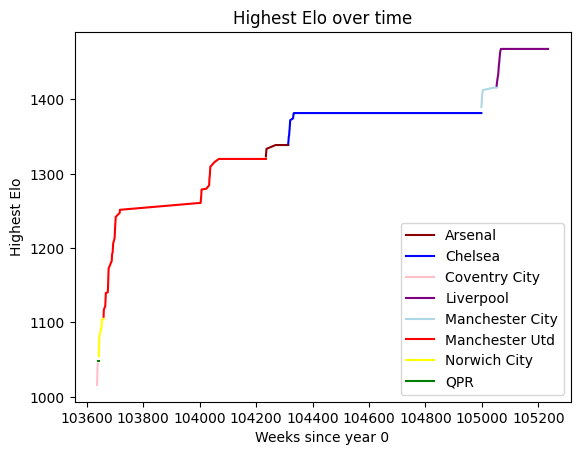

In [ ]:
# Define colors for each team
team_colors = {
    'Arsenal' : 'darkred',
    'Chelsea': 'blue',
    'Coventry City': 'pink',
    'Liverpool': 'purple',
    'Manchester City': 'lightblue',
    'Manchester Utd' : 'red', 
    'Norwich City' : 'yellow', 
    'QPR' : 'green',    # Add more teams as needed
}

# Plotting
teams = highest_ELO_ever[:,1]


# Create a new figure
plt.figure()


# Loop over each team
for team in np.unique(teams):
    team_data = highest_ELO_ever[teams == team]
    if(team == 'Arsenal'): 
        print( team_data)
    # Get the data for this team    
    # Extract the elo, week, and year
    elo = team_data[:, 0].astype(float)
    week = team_data[:, 3].astype(float)
    year = team_data[:, 2].astype(float)
    # Plot this team's data with its corresponding color
    plt.plot( 52* year +week, elo, color=team_colors[team], label=team)

# Add labels, title, and legend
plt.xlabel('Weeks since year 0')
plt.ylabel('Highest Elo')
plt.title('Highest Elo over time')
plt.legend()

# Show the plot
plt.show()
